In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./inpaintings_dataset")

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3006
    })
})

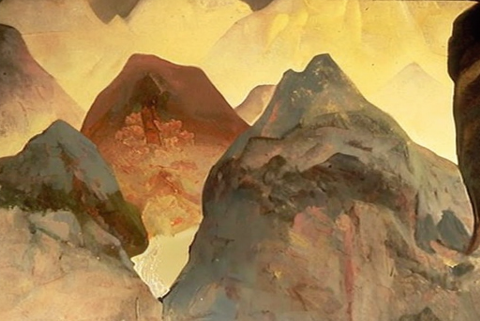

In [3]:
dataset['train'][1]['image']

In [4]:
labels = dataset['train'].features['label']
labels

ClassLabel(names=['inpainting', 'original'], id=None)

In [5]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = image_processor([x for x in batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = batch['label']
    return inputs

dataset = dataset.with_transform(transform)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [7]:
from torch.utils.data import DataLoader

import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

dataloader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=16, shuffle=True)

In [ ]:
from transformers import AutoModelForImageClassification

labels = dataset['train'].features['label'].names

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label={str(i): c for i, c in enumerate(labels)},
                                                        label2id={c: str(i) for i, c in enumerate(labels)},
                                                        ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [9]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(4):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])
    
    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/445 [00:00<?, ?it/s]

Loss after 0 steps: 0.6515673398971558
Accuracy after 0 steps: 0.5
Loss after 100 steps: 0.705777108669281
Accuracy after 100 steps: 0.5897277227722773
Loss after 200 steps: 0.25325483083724976
Accuracy after 200 steps: 0.6567164179104478
Loss after 300 steps: 0.613761842250824
Accuracy after 300 steps: 0.704734219269103
Loss after 400 steps: 0.2346237748861313
Accuracy after 400 steps: 0.7426745635910225
Epoch: 1


  0%|          | 0/445 [00:00<?, ?it/s]

Loss after 0 steps: 0.1774778962135315
Accuracy after 0 steps: 0.875
Loss after 100 steps: 0.09200633317232132
Accuracy after 100 steps: 0.9251237623762376
Loss after 200 steps: 0.08124953508377075
Accuracy after 200 steps: 0.9287935323383084
Loss after 300 steps: 0.08107378333806992
Accuracy after 300 steps: 0.9298172757475083
Loss after 400 steps: 0.35565701127052307
Accuracy after 400 steps: 0.9301745635910225
Epoch: 2


  0%|          | 0/445 [00:00<?, ?it/s]

Loss after 0 steps: 0.09235244989395142
Accuracy after 0 steps: 0.9375
Loss after 100 steps: 0.013296633027493954
Accuracy after 100 steps: 0.9851485148514851
Loss after 200 steps: 0.23287546634674072
Accuracy after 200 steps: 0.9835199004975125
Loss after 300 steps: 0.10997174680233002
Accuracy after 300 steps: 0.9788205980066446
Loss after 400 steps: 0.008129410445690155
Accuracy after 400 steps: 0.979426433915212
Epoch: 3


  0%|          | 0/445 [00:00<?, ?it/s]

Loss after 0 steps: 0.05101726949214935
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.05713693052530289
Accuracy after 100 steps: 0.994430693069307
Loss after 200 steps: 0.021318892017006874
Accuracy after 200 steps: 0.9937810945273632
Loss after 300 steps: 0.11487636715173721
Accuracy after 300 steps: 0.9912790697674418
Loss after 400 steps: 0.025825776159763336
Accuracy after 400 steps: 0.9922069825436409


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:

model.push_to_hub("VaggP/convnext-tiny-finetuned-for-inpaintings-in-art-detection")


In [ ]:
image_processor.push_to_hub("VaggP/convnext-tiny-finetuned-for-inpaintings-in-art-detection")